In [2]:
#%reset
import os
rundir='/space/hall3/sitestore/eccc/crd/ccrn/users/rms101/SCRIPTS/cfc/'
os.chdir(rundir)
import sys
sys.path.append('../PMODS')

import os
import cmipdata as cd
import numpy as np
import matplotlib.pyplot as plt # for basic plotting
import rms_plots as rpl1
import rms_utils as rut
import matplotlib as mpl
import xarray as xr
import nc as nc
import rms_utils_boot as rutb
from matplotlib.ticker import MultipleLocator
import glob
from scipy import stats
################settings
#mpl.style.reload_library()
plt.style.use('rms_paper')
ystart=1955;ystop=2005;nyear=ystop+1-ystart
years=np.arange(ystart,ystop+1)


registering cmaps
registering cmaps


In [3]:
# =====================================
# 1. Calculate and read data
# =====================================
exp_names={'historical':'historical',
           'fixODSO3':'hist-noCFC-noO3',
           'fixODS':'hist-noCFC',
           'fixaerosol':'hist-noaerosol',
           'fixCO2':'hist-noCO2'}


tas={};tas_zm={};files={}
nens=20;nyear_rm=5
# =====================================
# 1a. Calculate- annual means already done by CFC_TAS_Arc_Gm.ipynb 
# =====================================
# =====================================
# 1b. Read 
# =====================================          
##Model
os.chdir(rundir)

lon=nc.getvar('DATA/DATA_tas_canesm5_past_historical/am_tas_Amon_CanESM5_historical_r1i1p1f1_gn_185001-201412.nc','lon');nlon=np.size(lon)
lat=nc.getvar('DATA/DATA_tas_canesm5_past_historical/am_tas_Amon_CanESM5_historical_r1i1p1f1_gn_185001-201412.nc','lat');nlat=np.size(lat)

for forcing in exp_names.keys():
    os.chdir(rundir)
    os.chdir('DATA/DATA_tas_canesm5_past_{}'.format(exp_names[forcing]))
    files[forcing]=[]
    #make file lists
    for i in range(nens): 
        files[forcing].extend(glob.glob('am*_'+exp_names[forcing]+'_*r'+str(i+1)+'i1p2f1*'))               
    #declare variables
    tas[forcing]=np.zeros((nens,nyear,nlat,nlon))*np.nan
    tas_zm[forcing]=np.zeros((nens,nyear,nlat))*np.nan

    #read data
    for i,file in enumerate(files[forcing]):
        tasfile=xr.open_dataset(file)
        tas[forcing][i,:,:,:]=tasfile.tas.sel(time=slice('1955-01-01', '2005-12-31'))
        tas_zm[forcing]=np.mean(tas[forcing],axis=3)


In [9]:

##OBS
os.chdir(rundir)
tas_obs=np.zeros((nyear,nlat,nlon))*np.nan
tasfile=xr.open_dataset('DATA/DATA_tas_obs_past/SAT_HadCRUT_am_canesm5grid_1950_2005.nc')
tas_obs[:,:,:]=tasfile.tas_mean.sel(time=slice('1955-01-01', '2005-12-31'))
tas_obs_1950s=np.nanmean(tasfile.tas_mean.sel(time=slice('1950-01-01', '1960-12-31')),axis=0)
tas_zm_obs=np.nanmean(tas_obs,axis=2)
tas_zm_obs_1950s=np.nanmean(tas_obs_1950s,axis=1)
os.chdir(rundir)



/fs/homeu1/eccc/crd/ords/ccrn/rms101/.conda/envs/py2_rms_v2/lib/python2.7/site-packages/ipykernel_launcher.py:8: RuntimeWarning: Mean of empty slice
  


/fs/homeu1/eccc/crd/ords/ccrn/rms101/.conda/envs/py2_rms_v2/lib/python2.7/site-packages/ipykernel_launcher.py:49: RuntimeWarning: invalid value encountered in less


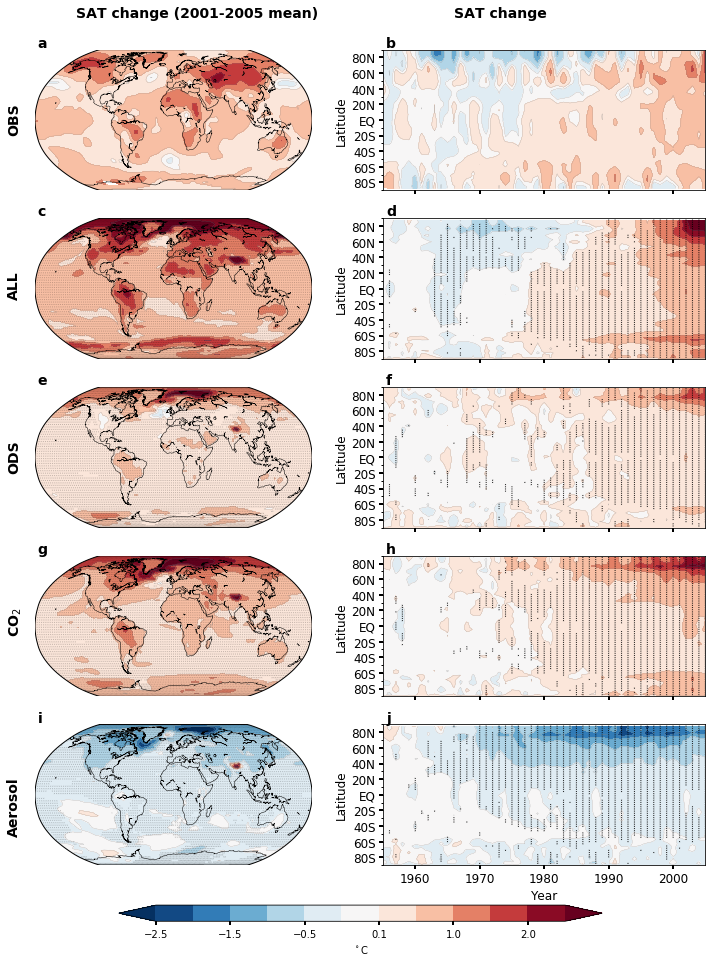

In [16]:
#==========================================================
#3. Plots  
#==========================================================
os.system('mkdir -p PLOTS')

labels={'historical':'ALL',
        'fixODS':'FixODS',
        'fixODSO3':'FixODSO$_3$',
        'fixaerosol':'Fixaerosol',
        'fixCO2':'FixCO$_2$'}

def plot_lonlat(ax,x,title,label=None,obs=False):
        #bm
        bm=rpl1.make_bm(ax,**bmparams);
        #cf
        if obs:
                cf=rpl1.add_cf(bm,lon,lat,x,**cfparams)
        else:
                cf=rpl1.add_cf(bm,lon,lat,np.mean(x,axis=0),**cfparams) 
                #sig
                sig=np.zeros([nlat,nlon])*np.nan
                sig[stats.ttest_1samp(x,0)[1]<0.05]=0.003
                lons,lats=np.meshgrid(lon,lat);bm.scatter(lons,lats,sig.squeeze(), facecolor='black',marker='x',latlon=True)
        #title
        rpl1.add_title(ax,title,label)
        return cf


def myax_latyear(ax):
  ax.set_ylim(-90,90)
  ax.set_xlim(1955,2005)
  ax.yaxis.set_major_locator(MultipleLocator(20))
  ax.yaxis.set_minor_locator(MultipleLocator(10))    
  ax.yaxis.set_ticks_position('left')  
  ax.set_yticks(np.arange(-80,100,20))
  ax.set_yticklabels(('80S','60S','40S','20S','EQ', '20N', '40N', '60N','80N'))
  
def plot_latyear(ax,x,title,label=None,obs=False):
    #axes
    myax_latyear(ax); 
    if not ax.is_last_row(): ax.set_xticklabels((''))
    ax.set_ylabel('Latitude',fontsize='large')
    if obs:
        cf=rpl1.add_cf(ax,years,lat,np.transpose(x),**cfparams)            
    else:
        cf=rpl1.add_cf(ax,years,lat,np.transpose(np.mean(x,axis=0)),**cfparams)  
        #sig
        sig=np.zeros([nyear,nlat])*np.nan
        sig[stats.ttest_1samp(x,0)[1]<0.05]=0.05
        lats,yearss=np.meshgrid(lat,years);ax.scatter(yearss,lats,sig, facecolor='black',marker='x')    
    #title
    rpl1.add_title(ax,title,label)
    return cf    


clevs=[-2.5,-2,-1.5,-1,-0.5,-0.1,0.1,0.5,1,1.5,2,2.5]
bmparams=dict(region='glob_rob')
cfparams=dict(clevs=clevs,cmap='RdBu_r')
#==========================================================
#3a. ALL+FixODSO3
#==========================================================

############### Setup fig
fig2, axs = plt.subplots(5,2, figsize=(11,15)); 
fig2.subplots_adjust(hspace=0.2,wspace=0.15,right=1)

plt.text(-0.1,0.55,'OBS',fontsize=14,rotation=90,transform=axs[0,0].transAxes,fontweight='bold')
plt.text(-0.1,0.55,'ALL',fontsize=14,rotation=90,transform=axs[1,0].transAxes,fontweight='bold')
plt.text(-0.1,0.55,'ODS',fontsize=14,rotation=90,transform=axs[2,0].transAxes,fontweight='bold')
plt.text(-0.1,0.55,'CO$_2$',fontsize=14,rotation=90,transform=axs[3,0].transAxes,fontweight='bold')
plt.text(-0.1,0.55,'Aerosol',fontsize=14,rotation=90,transform=axs[4,0].transAxes,fontweight='bold')

#lonlat plots
plt.text(0.15,1.23,'SAT change (2001-2005 mean)',fontsize=14,transform=axs[0,0].transAxes,fontweight='bold')
plot_lonlat(axs[0,0],np.mean(tas_obs[-nyear_rm::,:,:],axis=0)-tas_obs_1950s,'','a',obs=True)
plot_lonlat(axs[1,0],np.mean(tas['historical'][:,-nyear_rm::,:,:],axis=1)-tas['historical'][:,0,:,:],'','c')
plot_lonlat(axs[2,0],np.mean(tas['historical'][:,-nyear_rm::,:,:],axis=1)-np.mean(tas['fixODS'][:,-nyear_rm::,:,:],axis=1),'','e')
plot_lonlat(axs[3,0],np.mean(tas['historical'][:,-nyear_rm::,:,:],axis=1)-np.mean(tas['fixCO2'][:,-nyear_rm::,:,:],axis=1),'','g')
plot_lonlat(axs[4,0],np.mean(tas['historical'][:,-nyear_rm::,:,:],axis=1)-np.mean(tas['fixaerosol'][:,-nyear_rm::,:,:],axis=1),'','i')
plt.text(0.22,1.23,'SAT change',fontsize=14,transform=axs[0,1].transAxes,fontweight='bold')

#latyear plots
tas_zm_historical_cf1955=np.zeros((nens,nyear,nlat))*np.nan
for i in range(nens): tas_zm_historical_cf1955[i,:,:]=tas_zm['historical'][i,:,:]-tas_zm['historical'][i,0,:]

plot_latyear(axs[0,1],tas_zm_obs-tas_zm_obs_1950s,'','b',obs=True)
plot_latyear(axs[1,1],tas_zm_historical_cf1955,'','d')
plot_latyear(axs[2,1],tas_zm['historical']-tas_zm['fixODS'],'','f')
plot_latyear(axs[3,1],tas_zm['historical']-tas_zm['fixCO2'],'','h')
cf=plot_latyear(axs[4,1],tas_zm['historical']-tas_zm['fixaerosol'],'','j')

axs[4,1].set_xlabel('Year',fontsize='large') 
rpl1.add_cb(axs[4,1],cf,lscale=1.5,x0scale=0.1,y0scale=-5,orientation='horizontal',spacing='uniform',units='$^\circ$C')

rpl1.mysavefig(fig2,'PLOTS/TAS_pattern.png')







